In [30]:
import os
from os.path import isfile, join
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
#from scipy.ndimage import rotate
import cv2 
import json
from huggingface_hub import cached_download, hf_hub_url
from transformers import AutoModelForSemanticSegmentation
from transformers import AutoFeatureExtractor
from palette import *

In [31]:
### Load pretraint model to initialize parameters

repo_id = "huggingface/label-files"
#filename = "ade20k-hf-doc-builder.json" ### this file name was written in the tutorial, but it is not working
filename= "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

pretrained_model_name = "nvidia/mit-b0"
model = AutoModelForSemanticSegmentation.from_pretrained(
    pretrained_model_name, id2label=id2label, label2id=label2id
)

/Users/niche/miniconda3/envs/mymconda/lib/python3.9/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(
Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model c

In [32]:
### feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained("nvidia/mit-b0", reduce_labels=True)

In [40]:
### loding finetuned model
model.load_state_dict(torch.load('/Users/niche/Transformer_study/Trained_Model_with_50_images/pytorch_model.bin'))

<All keys matched successfully>

In [41]:
''' 
### loading an Image from Directory
### 

pathIn='./test_image/' ## study room 
#pathIn='./test_image/study_room.jpeg/' ## cow
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
files. sort(key=lambda f: int(''. join(filter(str. isdigit, f))))
#len(files)
for i in range(1):
        filename=pathIn + files[i]
        #reading each files
        image = cv2.imread(filename)

'''

#''' 
### loading an Image dataset
from datasets import load_dataset
ds = load_dataset("scene_parse_150") 
image= ds['train'][10]['image']
#'''

No config specified, defaulting to: scene_parse_150/scene_parsing
Found cached dataset scene_parse_150 (/Users/niche/.cache/huggingface/datasets/scene_parse_150/scene_parsing/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)
100%|██████████| 3/3 [00:00<00:00, 340.06it/s]


In [42]:
#image.shape ## for image in directory
image.size ## for image in dataset

(683, 512)

Process the image with a feature extractor and place the pixel_values on a GPU:



In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)

Pass your input to the model and return the logits:

In [44]:
outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()

Next, rescale the logits to the original image size:

In [45]:
### Run the following if image are chosen from the directory
upsampled_logits = nn.functional.interpolate(
    logits,
    #size=(image.shape[0],image.shape[1]), ## for image in directory
    size= image.size[::-1], ## for image in dataset
    mode="bilinear",
    align_corners=False,
)
pred_seg = upsampled_logits.argmax(dim=1)[0]

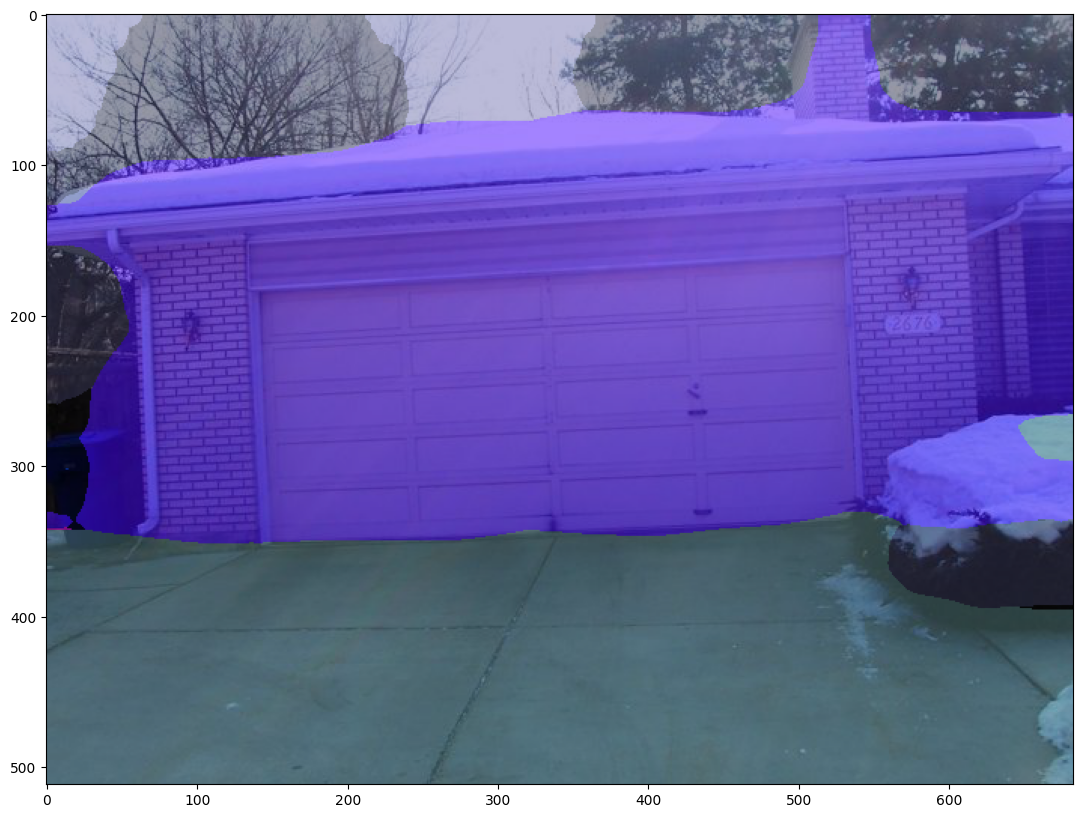

In [46]:
### visualize the results
color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()